
# Прогноз оттока клиентов телекоммуникационной компании

## Постановка задачи

Спрогнозировать возможность оттока клиентов у оператора связи. В исходных данных присутствует информация о персональных данных клиентов, тарифах оператора связи и договорах.

## План работ

- Первичный анализ данных
- Исследовательский анализ данных. Выбор признаков, которые будут использоваться при моделировании. Приведение признаков к нужному типу.
- Разработка моделей, подбор гиперпараметров.
- Проверка выбранной модели на на тестовой выборке. Анализ результатов моделирования. Определение признаков, наиболее сильно влияющих на результат.
- Описание выводов по работе.

## Первичный анализ данных

In [230]:
!pip install hyperopt

In [231]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle, class_weight

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from functools import partial

### Договор (contract.csv)

In [232]:
try:
    contract = pd.read_csv('contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [233]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


На первый взгляд в таблице отсутствуют пропуски. 

In [234]:
contract.sample(7)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3995,0618-XWMSS,2017-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),74.90,2068.55
1070,6166-ILMNY,2019-10-01,2019-12-01 00:00:00,Month-to-month,No,Bank transfer (automatic),69.75,144.55
1746,3963-RYFNS,2014-02-01,No,Two year,Yes,Bank transfer (automatic),116.45,8013.55
3421,6719-FGEDO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),97.00,7104.2
3323,4203-QGNZA,2017-10-01,No,Month-to-month,No,Mailed check,20.25,535.35
5261,1409-PHXTF,2015-08-01,No,Two year,Yes,Electronic check,110.45,6077.75
974,0604-THJFP,2015-03-01,No,Two year,Yes,Credit card (automatic),75.95,4542.35


Приведем данные к нужному типу данных.

**TotalCharges**

In [236]:
contract.loc[488]

customerID                         4472-LVYGI
BeginDate                          2020-02-01
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                                 
Name: 488, dtype: object

In [237]:
contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

Видим, что в столбце TotalCharges присутствуют пропуски в данных. Таких строк 11. Заменим их пока на значение NaN, а остальные значения в столбце приведем к типу float.

In [238]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['TotalCharges'] = contract['TotalCharges'].astype('float16')

**customerID**

In [240]:
contract['customerID'].value_counts()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

В столбце customerID присутствуют пользователи только с уникальными идентификаторами.

**BeginDate**

In [241]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')

In [242]:
contract['BeginDate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

In [243]:
contract.query('BeginDate == "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [244]:
contract['BeginDate'].min()

Timestamp('2013-10-01 00:00:00')

In [245]:
contract['BeginDate'].max()

Timestamp('2020-02-01 00:00:00')

Привели данные в столбце BeginDate к типу datetime64. Видим, что в таблице присутствуют записи, соответствующие пользователям, подключившимся к тарифам компании в период с 01.01.2013 по 01.02.2020. 

**EndDate**

В столбце EndDate одовременно присутствуют два признака: 1 - является ли пользователь клиентом компании, 2 - дата ухода клиента. Для дальнейшей работы лучше их разделить на 2 столбца. Введем новый столбец ChurnClient, где будет содержаться информация, является ли пользователь действующим клиентом компании: значение "0" будет соответствовать действующему клиенту, а значение "1" - ушедшему. В столбце EndDate останутся только даты.

In [246]:
contract['ChurnClient'] = 0

In [247]:
contract.loc[contract['EndDate'] != "No", 'ChurnClient'] = 1
contract['ChurnClient'] = contract['ChurnClient'].astype('uint8')

In [248]:
contract['ChurnClient'].value_counts()

0    5174
1    1869
Name: ChurnClient, dtype: int64

Из 7043 клиентов компании отказались от ее услуг 1869 пользователей, что состаляет 26,5%. Этот столбец в дальнейшем будем использовать в качестве целевого признака. Обратим сразу внимание на дисбаланс классов.

In [249]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

В столбце EndDate заменим значение "No" на дату вне рассматриваемого нами диапазона, ограниченного датой 2020-01-01. Установим у новых пользователей значение "2020-02-01".

In [250]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract['EndDate'].unique()

array(['2020-02-01', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Приведем значения в столбце EndDate к типу datetime64

In [251]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format = '%Y-%m-%d')

**Type**

In [252]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

В столбце Type, соответствующем типу договора, присутствует 3 воможных значения: Month-to-month, Two year, One year. Большинство пользователей (чуть больше 50%) выбирает тарифы, соответствующие договору "month-to-month".

**PaperlessBilling**

In [253]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

На первый взгляд данный столбец кажется бесполезным для решения нашей задачи и использования его в качестве одного из признаков.

**PaymentMethod**

In [254]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

У 3066 пользователей (почти половина всех пользователей) настроено авоматическое списание средств за использование услуг компании, что может быть одним из показателей лояльности пользователя и отсутствия желания уйти.

**MonthlyCharges**

In [255]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [256]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype('uint8')

Если анализировать полностью всех клиентов, можно увидеть, что среднее значение ежемесячного платежа (64,76) близко к медианному значению (70,35), но правый "хвост" распределения со значеними >64.76 немного больше. Размер ежемесячного платежа 50% всех клиентов лежит в диапазоне от 35,5 до 89,85, а размер платежа 25% наиболее прибыльных клиентов находи в диапазоне от 89,85 до 118,75.

Зафиксируем названия и расшифровку данных в столбцах таблицы

- **customerID** - идентификационный номер пользователя
- **BeginDate** - дата подключения
- **EndDate** - дата ухода пользователя
- **ChurnClient** - является ли клиентом в данный момент. Возможные значения: 0 - да, 1 - нет.
- **Type** - тип договора. Возможные значения: 
 - Month-to-month - договор "от месяца к месяцу"
 - One year - договор на год
 - Two year - договор два года
- **PaperlessBilling** - безбумажное выставление счетов. Возможные значения: Yes, No
- **PaymentMethod** - метод оплаты. Возможные значения: 
 - Electronic check - электронный чек
 - Mailed check - почтовый чек
 - Credit card (automatic) - кредитная карта (автоматически)
 - Bank transfer (automatic) - банковский перевод (автоматически)
- **MonthlyCharges** - ежемесячные платежи
- **TotalCharges** - платежи суммарно

### Персональные данные (personal.csv)

Создадим функцию для просмотра уникальных значений в столбцах таблиц.

In [257]:
def value_func(table):
    for item in table.columns:
        print(f'Столбец {item}')
        print(table[item].value_counts())
        print()

In [258]:
try:
    personal = pd.read_csv('personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [260]:
personal.sample(7)

,customerID,gender,SeniorCitizen,Partner,Dependents
3453,0326-VDYXE,Female,0,Yes,No
4338,9708-HPXWZ,Male,1,No,No
1730,3877-JRJIP,Male,0,No,No
2042,7361-YPXFS,Female,1,No,No
3555,6331-EWIEB,Male,0,No,No
1012,7426-RHZGU,Male,0,No,No
4434,0577-WHMEV,Female,0,Yes,No


In [261]:
value_func(personal)

Столбец customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Столбец gender
Male      3555
Female    3488
Name: gender, dtype: int64

Столбец SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Столбец Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Столбец Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64



В выборке практически одинаковое количество женщин и мужчин. Для прогнозирования оттока данный признак, скорее всего, будет бесполезным. Однако, он может пригодиться при формировании индивидуальных предложений. Дальнейшие исследования покажут, насколько он будет необходим. Среди пользователей пенсионеров - почти 20%. В выборке почти половина пользователей имеет партнера.Около 30% пользователей имеют иждивенцев.

In [262]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('uint8')

Зафиксируем пояснения по столбцам таблицы:

- **customerID** - идентификацинный номер пользователя.
- **gender** - пол. Возможные значения: Male, Female.
- **SeniorCitizen** - пенсионер. Возможные значения: 1 - да, 0 - нет.
- **Partner** - наличие партнера. Возможные значения: Yes, No.
- **Dependents** - наличие иждивенцев. Возможные значения: Yes, No.

### Интернет (internet.csv)

In [263]:
try:
    internet = pd.read_csv('internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [264]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [265]:
internet.sample(7)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4602,9943-VSZUV,Fiber optic,No,No,No,No,No,No
2072,7665-NKLAV,DSL,Yes,No,Yes,Yes,No,No
3059,0991-BRRFB,DSL,Yes,No,No,No,No,No
5172,8404-FYDIB,Fiber optic,Yes,Yes,No,No,No,No
84,7123-WQUHX,Fiber optic,No,No,Yes,Yes,Yes,No
4902,0489-WMEMG,DSL,No,No,No,Yes,No,No
1182,9809-IMGCQ,Fiber optic,No,No,No,No,Yes,Yes


В таблице inernet значительно меньше записей чем в таблице contract. Возможно, это означает, что услуга интернет клиенту не подключена. 

In [266]:
value_func(internet)

Столбец customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

Столбец InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Столбец OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

Столбец OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

Столбец DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

Столбец TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64

Столбец StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64

Столбец StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



Из подключившихся к интернету чуть больше половины (56%) выбрали способ подключения по оптоволокну, остальные - через DSL. Из подключившихся к услуге интернет только 36% воспользовались дополнительной услугой Онлайн-безопасность. Из подключившихся к услуге интернет 44% подключили дополнительную услугу по резервному копированию данных. Ситуация с услугой безопасности устройства аналогична резервному копированию. 37% пользователей выборки подключены к услугу техподдержки. К стриминговому ТВ и Кинотеатру подключены примерно по 50% пользователей выборки.

### Телефония (phone.csv)

In [267]:
try:
    phone = pd.read_csv('phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [268]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [269]:
phone.sample(7)

,customerID,MultipleLines
3483,6870-ECSHE,No
4836,6386-SZZKH,Yes
3656,2969-WGHQO,No
1413,2245-ADZFJ,Yes
3066,2696-RZVZW,Yes
4003,8042-RNLKO,Yes
1036,3082-WQRVY,No


В таблице phone записей также меньше чем в базовой таблице contract. Возможно, есть пользователи, которые подключены только к услуге "Интернет". Это станет понятно после объединения таблиц.

In [270]:
value_func(phone)

Столбец customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

Столбец MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64



Из 6361 пользователей, подключенных к телефонии, почти 47% также поключены к дополнительной услуге "Мультикональные линии".

### Вывод

В рамках данного этапа проведен первичный анализ данных. Каких-либо аномалий не обнаружено. В таблице contract выявлено 11 записей с отсутствующими данными по столбцу TotalCharges. Решение по их обработке/удалению примем на следующем этапе. Данные в таблицах приведены к типу, удобному для работы. В таблице contract на основе данных из столбца EndDate создан новый столбец ChurnClient, где содержится информация о том, яляется ли пользователь в данный момент клиентом компании. Данный столбец в дальнейшем послужит нам целевым признаком.

## Исследовательский анализ даных

### Предобработка данных

Объединим данные в единую таблицу по столбцу customerID, который присутствут во всех таблицах.

In [271]:
data = contract.merge(personal, on = 'customerID', how = 'left')
data = data.merge(internet, on = 'customerID', how = 'left')
data = data.merge(phone, on = 'customerID', how = 'left')

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   uint8         
 7   TotalCharges      7032 non-null   float16       
 8   ChurnClient       7043 non-null   uint8         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   uint8         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

Видим, что среди всех пользователей есть как те, кто подключен только к услуге Интернет, так и те, кто подключен только к услуге телефонии. Создадим столбец PhoneIn, в котором будет обозначаться факт подключения к услуге телефония. В столбце InternetService заполним отсутствующие данные значеним "No", что будет обозначать, что услуга не подключена.

In [273]:
data['PhoneIn'] = 'No'
data.loc[data['MultipleLines'] == data['MultipleLines'], 'PhoneIn'] = 'Yes'
data['MultipleLines'] = data['MultipleLines'].fillna('No')

In [274]:
data['InternetService'] = data['InternetService'].fillna('No')

In [275]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   uint8         
 7   TotalCharges      7032 non-null   float16       
 8   ChurnClient       7043 non-null   uint8         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   uint8         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    5517 n

Столбцы BeginDate и EndDate удалим, совсем, т.к. по условиям задачи они не нужны. Однако, введем новый столбец ServiceDuration, где будет содержаться информация о длительности предоставления клиенту услуг компании. Значения для столбца найдем как разницу между значениями дат в столбцах BeginDate и EndDate.

In [276]:
data['ServiceDuration'] = (data['EndDate'] - data['BeginDate']).dt.days

In [277]:
data = data.drop(['EndDate', 'BeginDate'], axis = 1)

Данные в столбце TotalCharges восстанавливать не будем. Его можно совсем удалить. Если его оставить, возникнет проблема с мультиколлинеарностью, т.к. он напрямую связан со столбцами MonthlyCharges и ServiceDuration. Значения в нем вычисляются путем перемножения значений из вышеуказанных столбцов. Столбец customerID также удалим, он нам больше не нужен.

In [278]:
data = data.drop(['TotalCharges', 'customerID'], axis = 1)

Отсутствующие значения в столбцах OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies заполним значением "No", т.к. если у пользователя не подключена услуга Интернет, то и дополнительные услуги не могут быть подключены.

In [279]:
data = data.fillna('No')

### Ежемесячный платеж

Рассмотрим более подробно статистики для столбца MonthlyCharges по пользователям, разбитым на группы действующих клиентов и ушедших.

In [281]:
# Статистики для действующих клиентов
data.query('ChurnClient == 0')['MonthlyCharges'].describe()

count    5174.000000
mean       60.797835
std        31.095702
min        18.000000
25%        25.000000
50%        64.000000
75%        88.000000
max       118.000000
Name: MonthlyCharges, dtype: float64

In [282]:
# Статистики для ушедших пользователей
data.query('ChurnClient == 1')['MonthlyCharges'].describe()

count    1869.000000
mean       73.979668
std        24.665506
min        18.000000
25%        56.000000
50%        79.000000
75%        94.000000
max       118.000000
Name: MonthlyCharges, dtype: float64

Из сравнения статистик для двух групп пользователей видим, что средний размер ежемесячного платежа у ушедших пользователей (73,98) больше чем у действующих клиентов (60,8). Ситуация с медианным значением аналогична: 79 против 64. Кроме того, среднемесячный платеж у 50% действующих клиентов лежит в диапазоне от 25 до 88 единиц, а у 50% ушедших пользователей в диапазоне от 56 до 94, т.е. значения всех квартилей у группы ушедших пользователей больше чем у оставшихся. Все это говорит о том, что одним из факторов, повлиявшим на уход пользователей, может быть размер среднемесячного платежа.   

Построим графики распределения для этих двух групп пользователей.

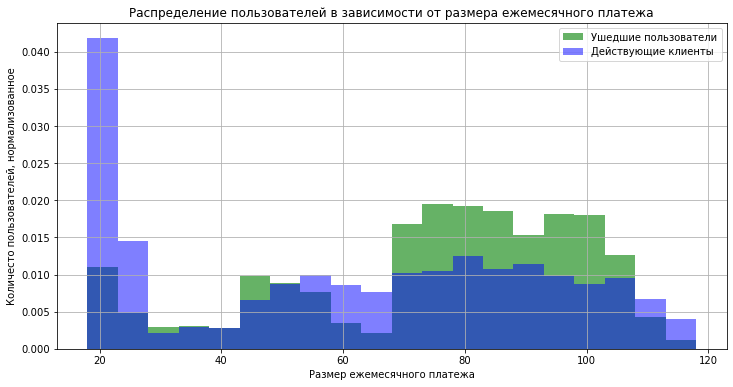

In [283]:
plt.figure(figsize = (12, 6))
data.query('ChurnClient == 1')['MonthlyCharges'].plot(x = 'MonthlyCharges', kind = 'hist', 
                                                 bins = 20, alpha = 0.6, 
                                                 color = 'green',  density = True)

data.query('ChurnClient == 0')['MonthlyCharges'].plot(x = 'MonthlyCharges', kind = 'hist', 
                                                 bins = 20, alpha = 0.5, 
                                                 color = 'blue', density = True)

plt.title('Распределение пользователей в зависимости от размера ежемесячного платежа')
plt.xlabel('Размер ежемесячного платежа')
plt.ylabel('Количесто пользователей, нормализованное')
plt.legend (('Ушедшие пользователи', 'Действующие клиенты'))
plt.grid()
plt.show()

По графику распределений видно, что всех пользователей условно можно разбить по размеру платежа на несколько кластеров: с размером платежа от 18 до 25 единиц, от 25 до 40 единиц, от 40 до 65 единиц и от 65 до 118 единиц. Эта информация может быть полезной для формирования дополнительных предложений по каждому кластеру тем клиентам, которые потенциально могут уйти. Распределение имеет вид мультимодального с пиками на 20, 50 и 80 единиц. Из графика также видно, что наибольшее количество действующих клиентов (чуть более 4%) имеют среднемесячный платеж в размере до 20 единиц, а среди ушедших пользователей около 15% имели платеж в размере от 70 до 100 единиц. 

### Продолжительность пользования услугами

Рассмотрим статистики признака ServiceDuration по группам пользователей.

In [284]:
data.query('ChurnClient == 1')['ServiceDuration'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: ServiceDuration, dtype: float64

In [285]:
data.query('ChurnClient == 0')['ServiceDuration'].describe()

count    5174.000000
mean     1144.447236
std       733.897937
min         0.000000
25%       457.000000
50%      1157.000000
75%      1857.000000
max      2191.000000
Name: ServiceDuration, dtype: float64

Из статистик видим, что среди ушедших пользователей 25% уходят в течение 2 месяцев, а 50% до конца года. 25% пользователей, наиболее долго пользовавшихся услугами компании, покидают компанию в срок от 29 до 72 месяцев. Распределение ушедших пользователей имеет динный правый "хвост". Для более наглядного представления построим график распределения для столбца ServiceDuration также по группам пользователей.

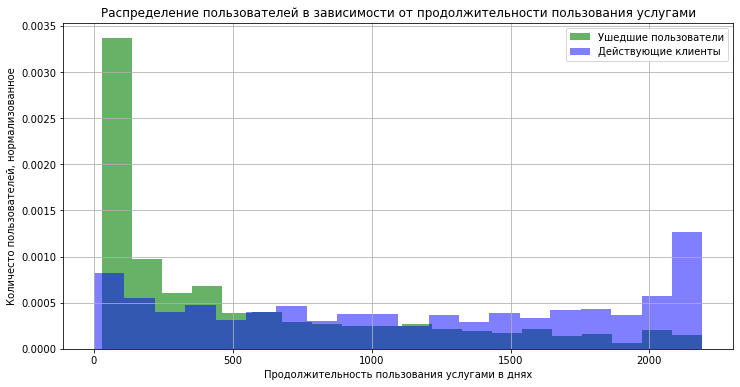

In [286]:
plt.figure(figsize = (12, 6))
data.query('ChurnClient == 1')['ServiceDuration'].plot(x = 'ServiceDuration', kind = 'hist', 
                                                 bins = 20, alpha = 0.6, 
                                                 color = 'green',  density = True)

data.query('ChurnClient == 0')['ServiceDuration'].plot(x = 'ServiceDuration', kind = 'hist', 
                                                 bins = 20, alpha = 0.5, 
                                                 color = 'blue', density = True)

plt.title('Распределение пользователей в зависимости от продолжительности пользования услугами')
plt.xlabel('Продолжительность пользования услугами в днях')
plt.ylabel('Количесто пользователей, нормализованное')
plt.legend (('Ушедшие пользователи', 'Действующие клиенты'))
plt.grid()
plt.show()

По графикам видим, что отток пользователей стабилен и равномерно распределен во всем временном диапазоне за исключением начального периода ориентировочно в 1 год, когда наблюдается небольшой пик ухода пользователей. Стоит отметить пик действующих клиентов, продолжающих пользоваться услугами компании больше 2000 дней. Вероятно, при запуске услуг пользователям были предложены особо выгодные условия, являющимся одним из факторов, влияющих на решение оставаться с компанией.

### Дополнительные интернет-услуги

Напишем функцию для построения графиков.

In [287]:
def func_fig(col_name, select_data = data):
    fig = plt.figure()
    
    for i, item in enumerate(col_name):
        axes = fig.add_subplot(math.ceil(len(col_name) / 2), 2, i + 1)
        sns.countplot(x = item, hue = "ChurnClient", data = select_data, ax = axes)
        
        axes.set_xlabel(item, fontsize = 12)
        axes.set_ylabel("Количество пользователей", fontsize = 12)
        plt.legend(('Действующие клиенты', 'Ушедшие пользователи'))    
        plt.grid()
    
    fig.set_figwidth(18)
    fig.set_figheight(5 * math.ceil(len(col_name) / 2))   
    plt.show()

Построим графики распределения для дополнительных интернет-услуг. Графики будем строить только для тех клиентов, кто подключен к интернету.

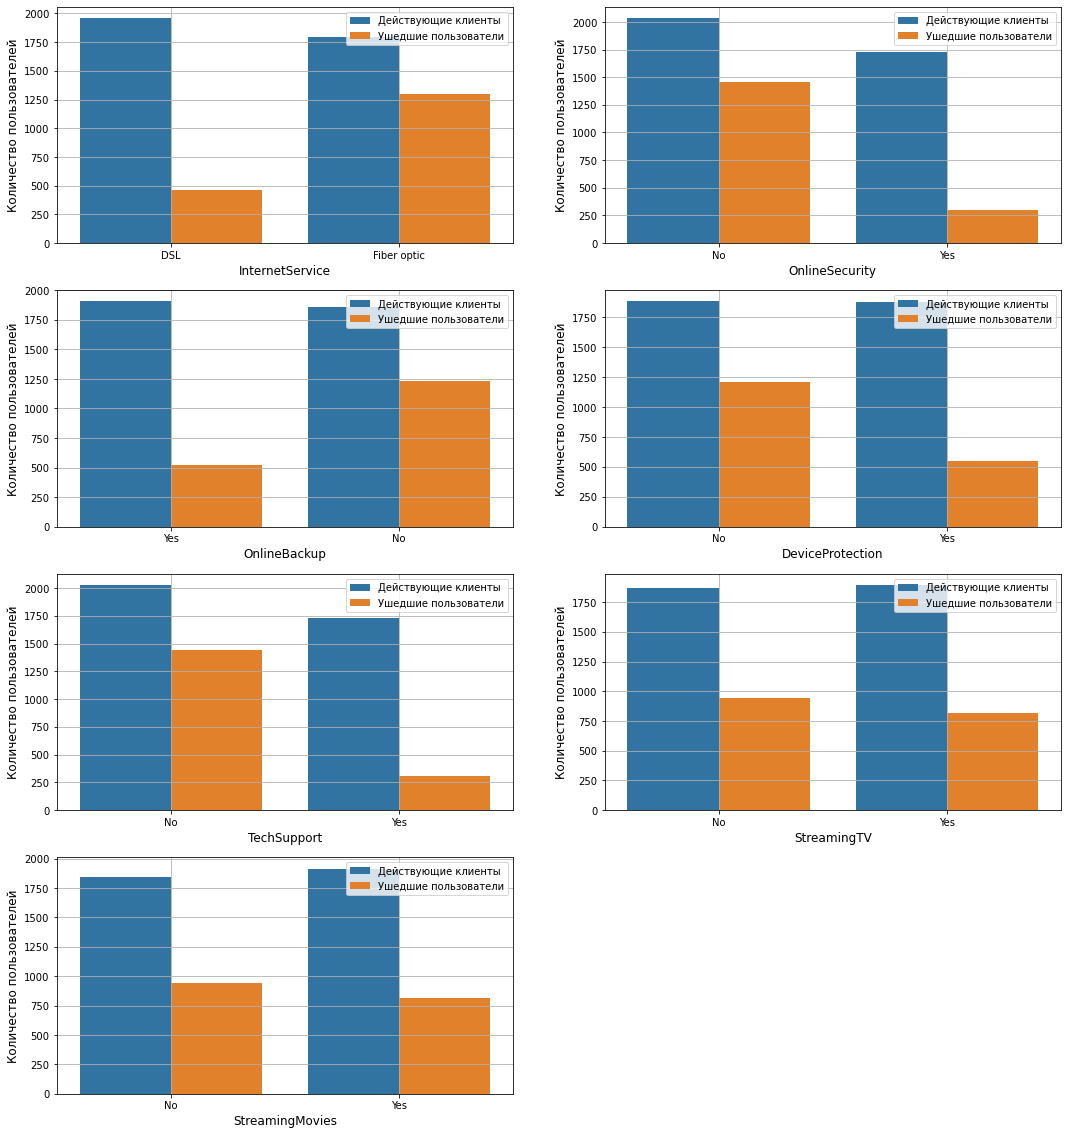

In [288]:
func_fig(internet.columns.drop('customerID'), data.query('InternetService != "No"'))

- По графикам видно, что из подключившихся к услуге Интернет наибольший отток наблюдается среди тех, кто подключился по оптоволокну, около 42%. Среди подключившихся по технологии DSL это количество составляет всего около 20%. 
- Всего 8% пользователей, подключивших услугу безопасности, покинули компанию. Отток среди тех, кто не подключил эту услугу значительно больше, около 43%.
- Пользователи, пользующиеся онлайн-бэкапом, в меньшей степени подвержены оттоку (около 21%) в отличии от не пользующихся данной услугой (около 40%). 
- Среди подключивших услугу по защите устройства наблюдается отток в размере около 20%. Среди не подключивших это значение значительно больше, около 42%.
- Аналогичная ситуация складывается с техподержкой. Отток среди пользующихся услугой около 12% и 43% среди тех, кто не подключился к ней.
- По услугам стримингового ТВ и Кино тендеции схожи. Отток около 33% среди подключивших одну из услуг и 36% среди не подключивших, т.е. факт подключения к одной из этих услуг не сильно влияет на отток клиентов.


В целом можно отметить, что если пользователь, подключившийся к интернету, пользуется хотя бы одной из набора дополнительных услуг OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, то вероятность его ухода меньше.

### Мультиканальная телефония

Построим график распределения по дополнительной услуге мультиканальной телефонии только для тех пользователей, которые подключены к услуге телефонии. 

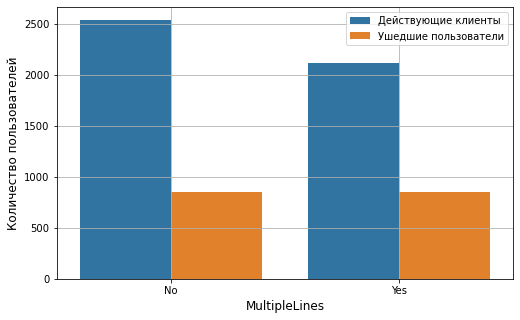

In [289]:
func_fig(phone.columns.drop('customerID'), data.query('PhoneIn == "Yes"'))

Из графика видно, что, хотя в абсолютном выражении количество ушедших пользователей примерно одинаково как для подключивших так и для не подключивших мультиканальную телефонию, но в относительном выражении ситуация другая. Из подключивших доп.услугу около 40% покинули компанию и только 32% ушли из тех, кто не подключался к ней.

### Интернет и телефония

Построим общий график распределения пользователей для подключившихся к услугам, разбив их на группы: Intrnet, Phone, Internet+Phone. 

In [290]:
data.loc[data['InternetService'] != 'No', 'Services'] = 'Internet'
data.loc[data.query('InternetService == "No" & PhoneIn == "Yes"').index, 'Services'] = 'Phone'
data.loc[data.query('InternetService != "No" & PhoneIn == "Yes"').index, 'Services'] = 'Internet+Phone'

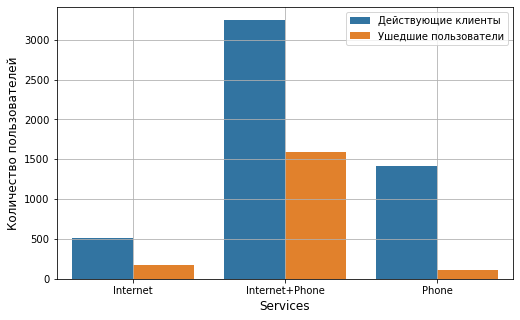

In [291]:
func_fig(['Services'])

По графикам видим, что наибольшее количество пользователей подключается одновременно к 2 услугам, отток около 30%. Но самый большой отток наблюдается в группе пользователей, подключенных только к интернету, около 40%. Среди подключившихся только к телефонии отток самый маленький, около 6%.

Построим гистограммы распределения пользователей по среднемесячнму платежу, разбитых на вышеприведенные группы.

In [292]:
serv_name = data['Services'].unique()

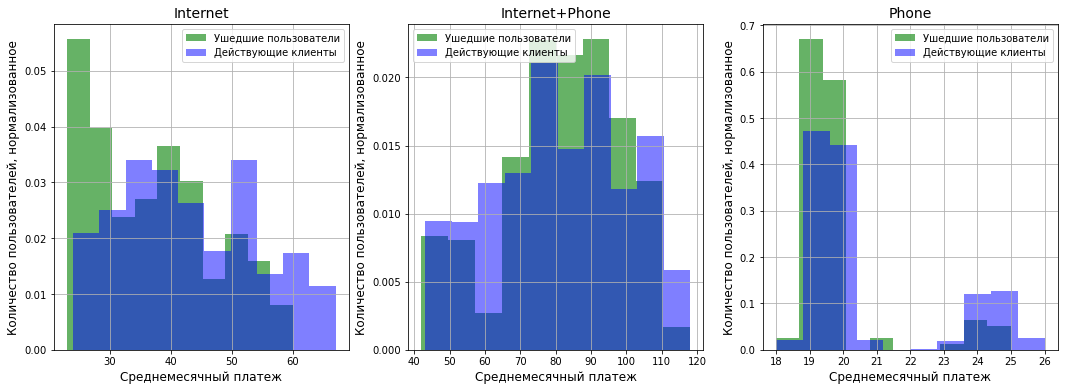

In [293]:
fig = plt.figure()

for i in range(len(serv_name)):
    axes = fig.add_subplot(1, 3, i + 1)
    service = serv_name[i]
    data.query('ChurnClient == 1 & Services == @service')['MonthlyCharges'].plot(x = 'MonthlyCharges', kind = 'hist', 
                                    bins = 10, alpha = 0.6, color = 'green',  density = True, ax = axes)

    data.query('ChurnClient == 0 & Services == @service')['MonthlyCharges'].plot(x = 'MonthlyCharges', kind = 'hist', 
                                    bins = 10, alpha = 0.5, color = 'blue', density = True)
        
    plt.grid()
    axes.set_title(service, fontsize = 14)
    axes.set_xlabel('Среднемесячный платеж', fontsize = 12)
    axes.set_ylabel("Количество пользователей, нормализованное", fontsize = 12)
    plt.legend(('Ушедшие пользователи', 'Действующие клиенты'))
        
fig.set_figwidth(18)
fig.set_figheight(6)
plt.show()

Из отдельных гафиков по группам пользователей становится понятно, почему рапределение по всей выборке имеет мультимодальный вид. Пользователи, подключившиеся только к телефонии, по среднемесячному платежу выделяются в 2 отдельные подгруппы, не пересекающиеся с другими. Дальше идет группа, подключившихся только к интернету, котоая частично пересекается в диапазоне ежемесячной оплаты от 42 до 68 единиц с группой пользователей ,подключившихся к общему пакету.

Среди пользователей, подключившихся только к телефонии, наибольший отток наблюдается с минимальной оплатой от 19 до 20 единиц. Среди тех, платит от 24 до 25 единиц в месяц отток пользователей значительно меньше. Аналогичная тенденция наблюдается и среди тех, кто подключилсятолько к интернету с ежемесячной оплатой от 10 до 30 единиц.

Было бы интересно посмотреть действующих клиентов и ушедших пользователей в разрезе ежемесячного платежа и длительности использования услуг компании.

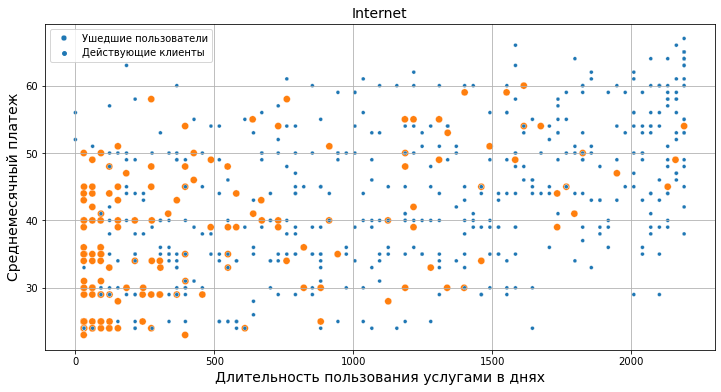

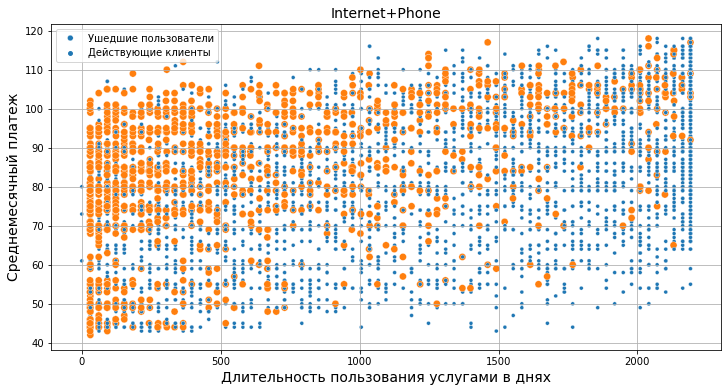

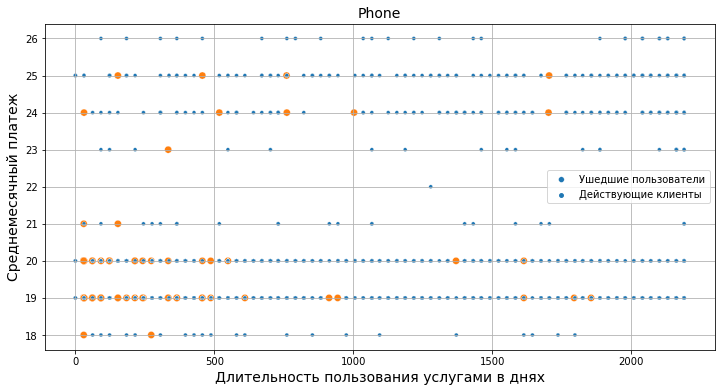

In [294]:
for i in range(len(serv_name)):
    plt.figure(figsize=(12, 6))
    service = serv_name[i]
    
    graf = sns.scatterplot(x = 'ServiceDuration', y = 'MonthlyCharges', 
                       data = data.query('Services == @service'), 
                       hue = 'ChurnClient', size = 'ChurnClient', sizes=(50, 15))
    
    graf.axes.set_title(service, fontsize=14)
    graf.set_xlabel("Длительность пользования услугами в днях", fontsize=14)
    graf.set_ylabel("Среднемесячный платеж", fontsize=14)
    plt.legend(('Ушедшие пользователи', 'Действующие клиенты'))
    plt.grid()
    plt.show()

Среди пользователей, подключенных только к телефонии, также по средемесячному платежу выделяются 2 кластера с границей на 22 единицах. Отток пользователей тем меньше чем больше срок пользования услугами. Аналогичная тенденция просматривается и для тех пользователей, кто подключен только к интернету. Среди пользователей, подключенных и к интернету и к телефонии, также просматривается разделение на 2 кластера с границей среднемесячной оплаты в 65 единиц. В кластере до 65 единиц отток пользователей явно меньше чем в кластере с более высокой средемесячной оплатой. Особенно явно это видно после 500 дней пользования услугами. Явной корреляции между признаками здесь, кстати, не видно.

Просматриваемые кластеры, возможно, определяются существующими тарифами на услуги. Если бы Заказчиком была предоставлена информация о тарифах это стало бы понятно.

### Другие признаки

Построим графики распределения для остальных признаков.

In [295]:
name_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 
                 'Partner', 'Dependents', 'InternetService', 'PhoneIn']

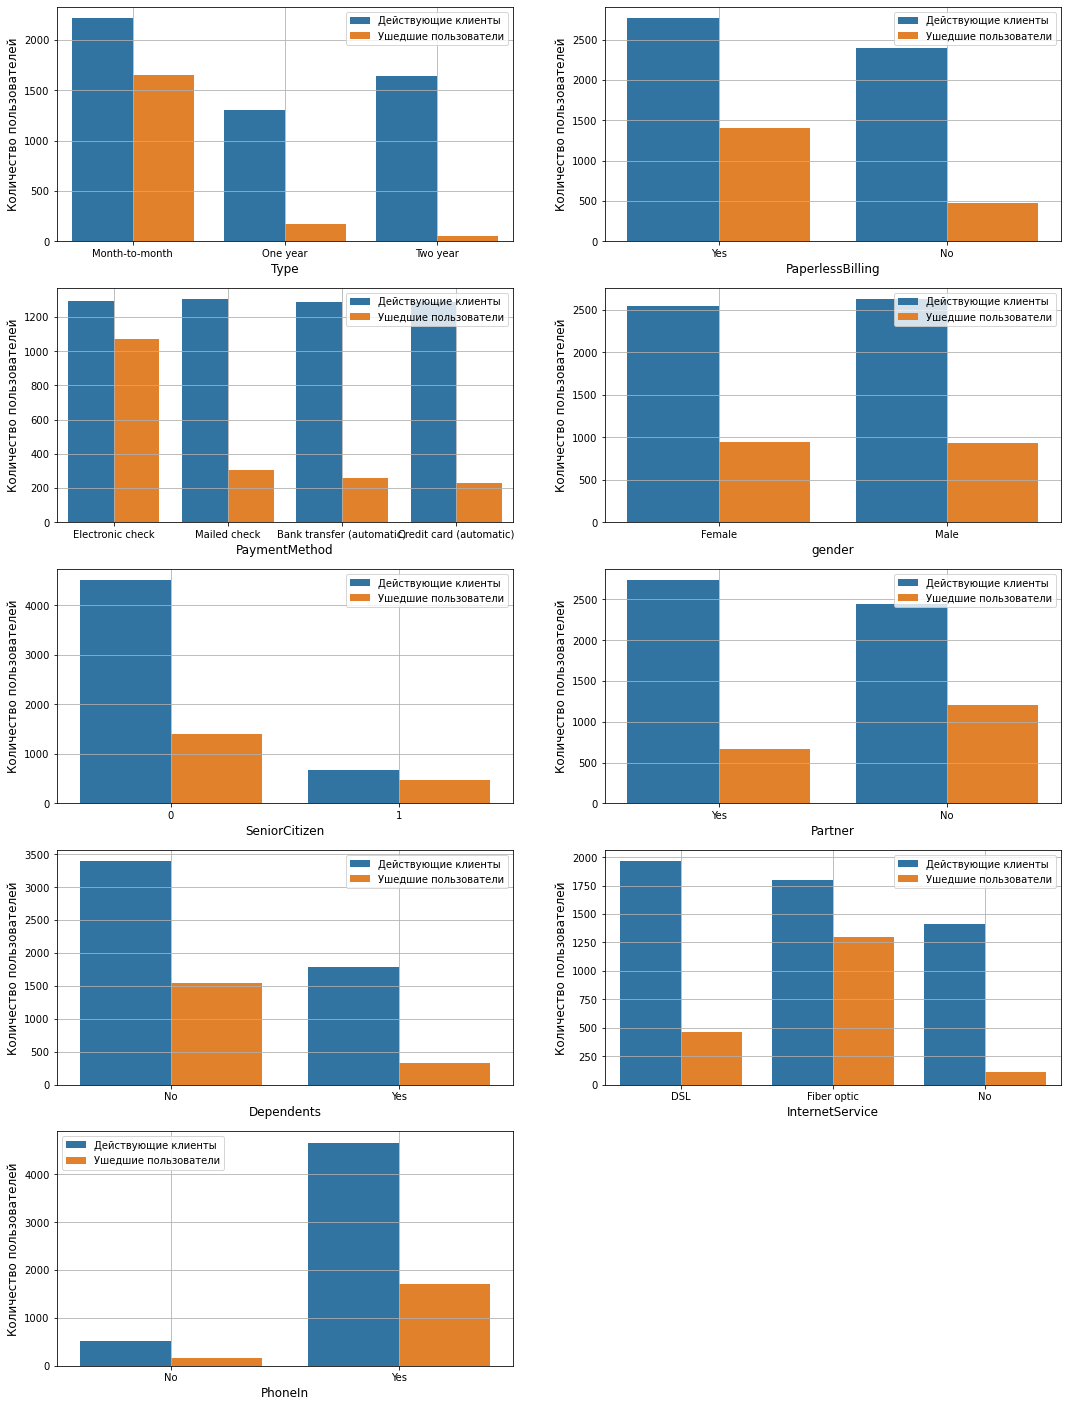

In [296]:
func_fig(name_features)

- Наибольший отток пользователей просматривается у тех, кто подключился по договору "без обязательств" (month-to-month), где процент оттока составлется около 40%. У пользователей с иными договорами он не более 20%.
- Среди тех пользователей, которые пользуются безбумажным биллингом отток значительно больше чем среди тех, кто им не пользуется, 35% против 16%.
- По методу оплаты наибольший отток пользователей наблюдается у тех, кто пользуется электронным чеком - около 50%.
- Пол, вероятно, не является фактором, определяющим отток пользователей. и этотпризнак можно удалить.
- Среди пенсионеров очнь большой отток пользователей, около 50%. У непенсионеров - всего около 25%. 
- Отток пользователей среди тех, кто имеет партнера, около 20%, у свободных от обязательств пользователей - около 32%.
- Среди тех, кто имеет иждевенцев, наблюдается отток около 13% в отличии от тех, кто их не имеет, где отток около 30%. 
- Анализируя график, можно сказать, что среди неподключившихся к интернету самый небольшой процент ушедших пользователей, который составляет около 10% от общего количеста неподключившихся. Наибольший отток наблюдается среди тех, кто подключен к интернету по оптоволокну, наибольший отток пользователей наблюдается - около 40%. Возможно, это связано со стоимостью или качеством предоставляемых услуг. Отток клиент среди клиентов, подключившихся по технологии DSL, составляет около 20%.
- Среди тех пользователей, у кого была подключена услуга телефонии соотношение действующих к ушедшим составляет ориентировочно 1:3, а среди не подключившихся это соотношение составляет 1:2. Это означает, что, если пользователь не подключен к телефонии, вероятность его ухода больше, чем в случае его подключения к услуге.

### Вывод

По итогам исследовательского анализа данных были выявлены некоторые закономерности в поведении пользователей, среди котрых можно выделить следующие:
- Пользователи в большинстве случаев покидают компанию в первые 10 месяцев ползования услугами;
- Среди всех пользователей наибольший отток наблюается у тех, кто подключился по краткосрочному договору "Month-to-month";
- Размер среднемесячного платежа 25% наименее доходных пользователей, покинувших компанию, лежит в диапазоне до 56 единиц, тогда как у 25% тех же клиентов, продолжающих пользоваться услугами компании, не превышает 25 единиц;
- Если пользователи, подключившиеся у интернету, выбирают какую-либо дополнительную интернет-услугу, то вероятность их оттока меньше чем без дополнителных услуг;
- В телефонии наоброт: при выборе доп.услуги "Мультиканальное подключение" вероятность оттока клиента повышается. Возможно, это связано с качеством услуги.
- Большой вес в принятии решения об уходе имеет признак "PaperlessBilling";
- Кроме того, если пользователь - пенсионер, использует тип оплаты "Electronic check" или подключился к интернету по оптоволокну, то вероятность его ухода также повышается.

## Подготовка выборок

Удалим столбец PhoneIn, т.к. вся информация о телефонии содержится в MultipleLines и столбец Services, использованный для исследования.

In [298]:
features = data.drop(['PhoneIn', 'Services'], axis = 1)

### Мультиколлинеарность

Проверим числовые признаки на наличие мультиколлинеарности.

In [303]:
numeric = ['MonthlyCharges', 'ServiceDuration']

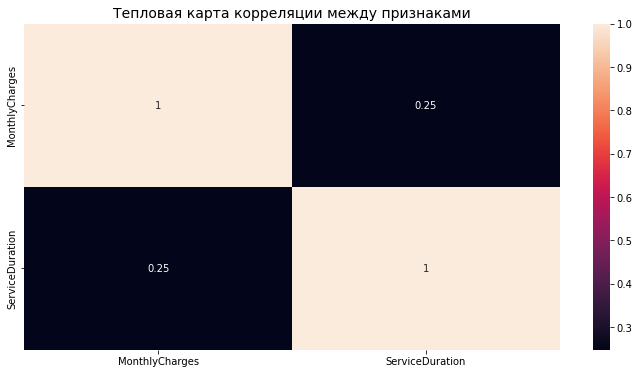

In [304]:
plt.figure(figsize=(12, 6))
sns.heatmap(features[numeric].corr(), cbar = True, annot = True)
plt.title("Тепловая карта корреляции между признаками", fontsize = 14)
plt.show()

Сильной корреляции между чисовыми признаками не наблюдается, т.е. мультиколлинеарности здесь нет.

Рассмотрим корреляции и числовых и категориальных признаков в целом. 

In [305]:
interval_cols = ['MonthlyCharges', 'ChurnClient', 'SeniorCitizen', 'ServiceDuration', 'Contract']
phik_overview = features.phik_matrix(interval_cols = interval_cols)

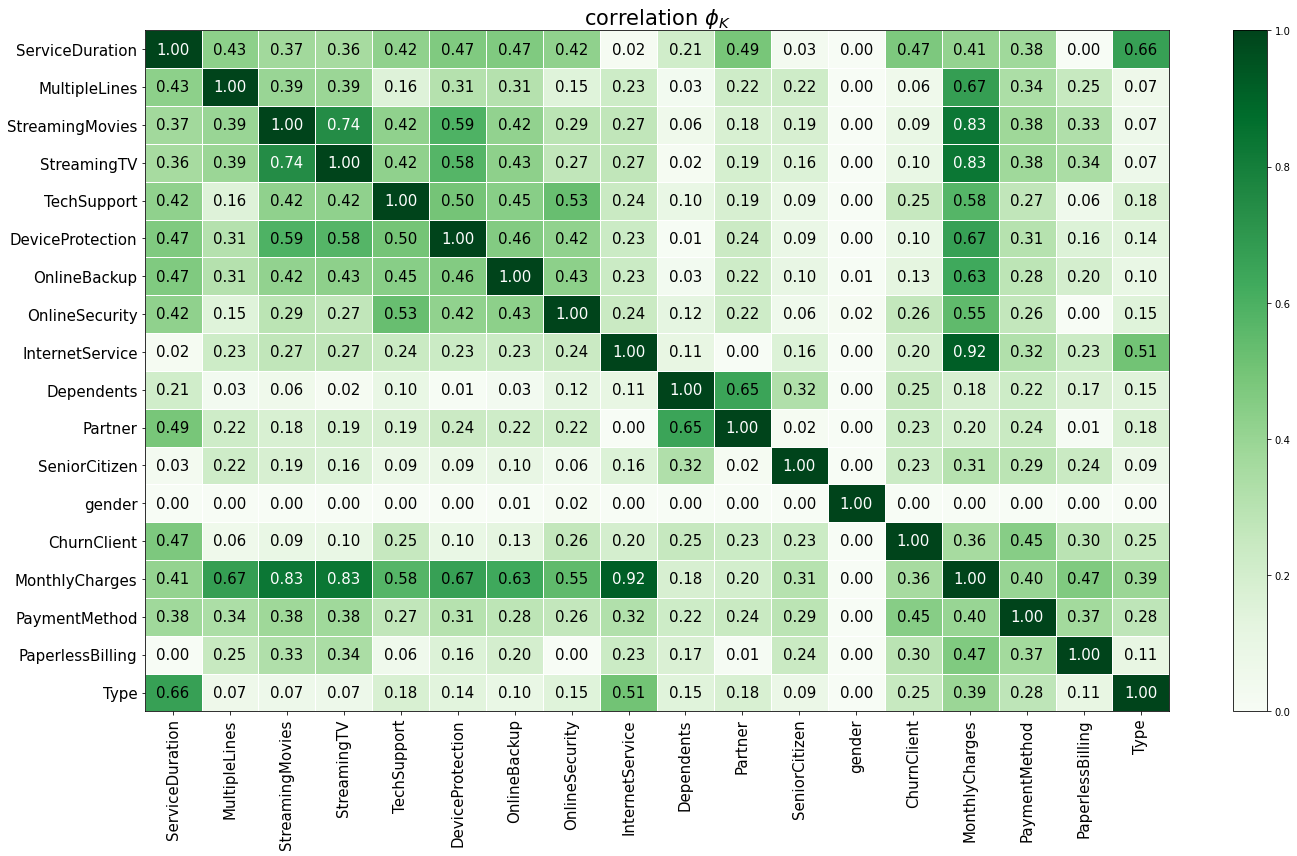

In [306]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels = phik_overview.columns, 
                        y_labels = phik_overview.index, 
                        vmin = 0, vmax = 1, color_map = "Greens", 
                        title = r"correlation $\phi_K$", 
                        fontsize_factor = 1.5, 
                        figsize = (20, 12))
plt.tight_layout()

Обращает внмание на себя средняя корреляция признака MonthlyCharges со всеми признаками, обозначающими услуги. И это объяснимо, т.к. если есть услуга, то есть и плата за нее. В идеале от нее можно было бы избавиться, если бы в таблице вместо простого обозначения услуги Yes/No присутствовало значение месячной оплаты за нее. Особенно высокая корреляция наблюдается между признаками StreamingMovies и StreamingTV. Видимо, чаще всего эти дополнительые услуги заказывают вместе одним пакетом. Также несколько повышенное значение корреляции прсоматривается у признаков Partner и Dependents, но не столь значимое.

### Кодирование

Закодируем катаегориальные признаки методом One-Hot Encoding

In [307]:
features = pd.get_dummies(features, drop_first = True)

In [308]:
features.sample(5)

,MonthlyCharges,ChurnClient,SeniorCitizen,ServiceDuration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4392,19,0,0,31,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
6247,89,0,0,1826,0,1,1,0,1,0,...,0,1,0,0,0,1,0,1,0,1
1420,99,0,0,1826,0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,1,1
6481,69,0,0,153,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1316,19,0,0,215,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


### Масштабирование

Создадим тренировочную и тестовую выборки.

In [309]:
train_features, test_features, train_target, test_target = train_test_split(features.drop(['ChurnClient'], axis = 1), 
                                                features['ChurnClient'], test_size = 0.2, random_state = 250722,
                                                stratify = features['ChurnClient'])

Проведем масштабирование численных признаков

In [310]:
scaler = StandardScaler()
scaler.fit(train_features[numeric])

StandardScaler()

In [311]:
train_features[numeric] = scaler.transform(train_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

### Дисбаланс классов

Как ранее было установлено, в целевом признаке присутствует дисбаланс классов 

In [312]:
train_target.value_counts()

0    4139
1    1495
Name: ChurnClient, dtype: int64

Устраним его, увеличив количество записей со значением, равным "1".

In [313]:
train_target_zero = train_target[train_target == 0]
train_target_one = train_target[train_target == 1]

In [314]:
train_features_zero = train_features.loc[train_target_zero.index]
train_features_one = train_features.loc[train_target_one.index]

In [315]:
train_features = pd.concat([train_features_zero] + [train_features_one] * 2)
train_target = pd.concat([train_target_zero] + [train_target_one] * 2)

train_features = shuffle(train_features, random_state = 250722)
train_target = shuffle(train_target, random_state = 250722)

In [316]:
train_features.shape

(7129, 21)

### Вывод

На этапе подготовки данных было проведено кодирование категориальных признаков методом One-Hot-Encoding. Числовые признаки были масштабированы. Все лишние столбцы, не нужые для формирования признаков быи удалены из таблицы. С использованием стратификации сформированы тренировочная и тестовая выборки. Для устранения дисбаланса классов проведено увеличение класса "1" методом upsampling.

## Разработка моделей

Создадим функцию для подбора параметров разрабатываемых моделей.

In [317]:
def hyperopt_score(params, x_train, y_train, type_model):
    model = type_model(**params, random_state = 250722)
    current_score = cross_val_score(model, x_train, y_train, scoring = 'roc_auc', cv = 5).mean()
    
    return {'loss': -current_score, 'params': params, 'status': STATUS_OK}

Заготовим таблицу, куда будем сохранять полученные метрики наших моделей.

In [318]:
model_metric = pd.DataFrame(index=['roc_auc'], columns=['Tree', 'RF', 'LR'])

Начнем разработку моделей с наиболее простых.

### Дерево решений

In [319]:
space = {'max_depth': hp.choice('max_depth', range(1, 60)), 'class_weight' : 'balanced'}

In [320]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, x_train = train_features, y_train = train_target, 
                         type_model = DecisionTreeClassifier), space = space, algo = tpe.suggest, 
                         max_evals = 20, trials = trials)

100%|██████████| 20/20 [00:03<00:00,  5.47trial/s, best loss: -0.8740677921042929]


In [321]:
model_metric.loc['roc_auc', 'Tree'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 3)

{'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth']}

{'max_depth': 57}

In [322]:
model_metric

,Tree,RF,LR
roc_auc,0.874,NaN,NaN


Разработаная модель Дерево решений с максимальной глубиной дерева max_depth = 57 показала значение метрики AUC-ROC = 0,874, которое значительно превышает значение условной сучайной модели с AUC-ROC = 0,5. Посмотрим другие модели.

### Случайный лес

In [323]:
space = {'max_depth': hp.choice("max_depth", np.arange(1, 25, dtype = int)),
        'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int))}

In [324]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, x_train = train_features, y_train = train_target, 
                         type_model = RandomForestClassifier), space = space, algo = tpe.suggest, 
                         max_evals = 20, trials = trials)

100%|██████████| 20/20 [00:19<00:00,  1.04trial/s, best loss: -0.9444860162673769]


In [325]:
model_metric.loc['roc_auc', 'RF'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 3)

{'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
 'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators']}

{'max_depth': 24, 'n_estimators': 55}

In [326]:
model_metric

,Tree,RF,LR
roc_auc,0.874,0.944,NaN


Модель Случайный лес с максимальной глубиной дерева max_depth=24 и количеством деревьев n_estimators=55 показала результат еще лучше - AUC-ROC = 0,944, что вполне предсказуемо.

### Логистическая регрессия

In [327]:
model = LogisticRegression(random_state = 250722, solver = 'liblinear', class_weight = 'balanced')

In [328]:
model_metric.loc['roc_auc', 'LR'] = round(cross_val_score(model, train_features, train_target, 
                                                         scoring = 'roc_auc', cv = 5).mean(), 3)

In [329]:
model_metric

,Tree,RF,LR
roc_auc,0.874,0.944,0.848


Логистическая регрессия показала результат AUC-ROC=0,848 несколько ниже расмотренных выше моделей. 

### XGBClassifier

In [330]:
space = {
    'max_depth': hp.choice("max_depth", np.arange(1, 20, dtype = int)),
    'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int)),
}

In [331]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = train_features, y_train = train_target, 
                         type_model = XGBClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 20, trials = trials)

100%|██████████| 20/20 [00:36<00:00,  1.80s/trial, best loss: -0.9611759595405817]


In [332]:
model_metric.loc['roc_auc', 'XGB'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 3)

{'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
 'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators']}

{'max_depth': 11, 'n_estimators': 58}

In [333]:
model_metric

,Tree,RF,LR,XGB
roc_auc,0.874,0.944,0.848,0.961


Модель XGBClassifier с максимальной глубиной дерева max_depth=11 и количеством деревьев n_estimators=58 пока показывает наилучший результат AUC-ROC=0,961. Рассмотрим еще одну модель, использующую градиентный бустинг - LGBMClassifier.

### LGBMClassifier

In [334]:
space = {'max_depth': hp.choice("max_depth", np.arange(1, 15, dtype = int)),
        'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int)),
        'num_leaves' : hp.choice("num_leaves", np.arange(5, 31, dtype = int))}

In [335]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = train_features, y_train = train_target, 
                         type_model = lgb.LGBMClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 20, trials = trials)

100%|██████████| 20/20 [00:06<00:00,  2.94trial/s, best loss: -0.8965490619992051]


In [336]:
model_metric.loc['roc_auc', 'LGBM'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 3)

In [337]:
{'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
 'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators'],
 'num_leaves' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['num_leaves']}

{'max_depth': 7, 'n_estimators': 37, 'num_leaves': 20}

In [338]:
model_metric

,Tree,RF,LR,XGB,LGBM
roc_auc,0.874,0.944,0.848,0.961,0.897


Модель LGBM с гиперпараметрами max_depth=7, n_estimators=37 и num_leaves=20 показала чуть хуже результат AUC-ROC=0,897 в сравнении с моделями XGB и с RandomForest. 

### Анализ модели

Наилучший результат на тренировочной выборке показала модель XGBClassifier с гиперпараметрами max_depth=15, n_estimators=43. Метрика AUCROC для данной модели показала значение =0,961. Она и будет выбана для дальнейшего анализа. Проведем тестирование выбранной модели на тестовой выборке и посмотрим дополнителные метрики: f1 и accuracy. Также построим кривую ошибок.

In [339]:
model = XGBClassifier(random_state = 250722)
model.fit(train_features, train_target)

probabilities_test = model.predict_proba(test_features)
probabilities_test_ones = probabilities_test[:, 1]
predicted_test = model.predict(test_features)
fpr, tpr, threshold = roc_curve(test_target, probabilities_test_ones)

print('f1_score:', f1_score(test_target, predicted_test))
print('Recall:', recall_score(test_target, predicted_test))
print('Accuracy:', precision_score(test_target, predicted_test))
print('AUC-ROC', roc_auc_score(test_target, probabilities_test_ones))

f1_score: 0.753315649867374
Recall: 0.7593582887700535
Accuracy: 0.7473684210526316
AUC-ROC 0.9105156423570746


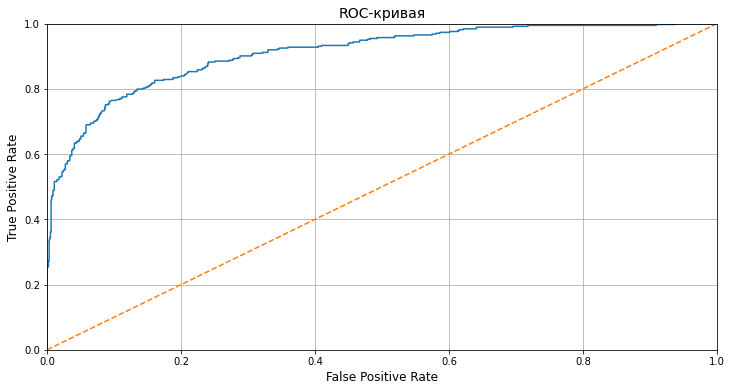

In [340]:
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title("ROC-кривая", fontsize=14)
plt.grid()
plt.show()

На тестовой выборке модель XGBClassifier показала себя не сильно хуже чем на тренировочной, AUC-ROC=0,91. Требование Заказчика выполнено.  

Если смотреть на другие метрики, то судя, по значению метрики Accuracy=0,75, модель достаточно точно определяет возможность уход/неухода пользователя. В 75% случаев дает правильный ответ. Однако, взглянув на значение метрики Recall=0,76, можно понять, что модель отлавливает только 75,9% истинноположительных уходов пользователей. Значение метрики f1=0,75 в целом показывает неплохое качество машинного обучения.

При желании по графику ROC-кривой можно подобрать такое значение порога классификации (соотношение парметров TPR и FPR), которое удовлетворит требования Заказчика. К примеру, пожертвовать точностью определения вероятности ухода пользователя (увеличится FPR), но зато повысить полноту определения истиннополжительных значений (TPR).

### Важность признаков

Построим график важности признаков, воспользовавшись методом plot_importance библиотеки xgboost.

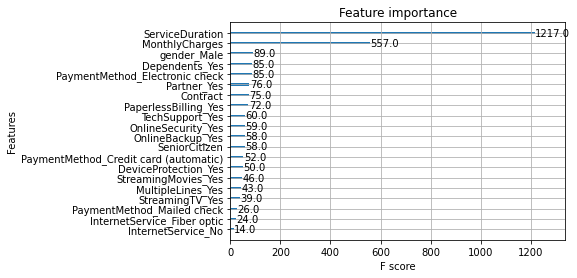

In [155]:
plot_importance(model)
plt.show()

Предсказуемо наиболее важными признаками для предсказания оказались длительность пользования услугой, ежемесячный платеж и тип договора. Далее идут метод оплаты электронным чеком, наличие иждевенцев и безбумажный биллинг. При наличии значительного количества признаков, которые могу вносить шум в модель и усложнять ее работу, от части принзаков можно было бы отказаться. В нашем случае модель работает прекрасно, можно оставить все как есть. Заказчику также стоит прежде всего обращать внимание именно на эти признаки, чтобы понять, готов пользователь уйти или нет.

### Вывод

На тренировочной выборке было обучено несколько моделей с кроссвалидацией: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, XGBClassifier, LGBMClassifier. Для подбора гиперпараметров использовался метод байесовской оптимизации, реализованный в пакете hyperopt. Наилучшие результаты показала модель XGBClassifier. На тестовых данных модель выдала значения метрик AUC-ROC=0,98, f1_score=0,916, Accuracy=0.948. Условия задачи выполнены.

# Выводы

В рамках данного исследования был проведен анализ данных об оттоке пользователей телекоммуникационной компании и построены модели его предсказания.

После первичного анализа данных было произведено более углубленное изучение признаков, содержащихся в таблицах. Были выявлены  некоторые закономерности в поведении пользователей в зависимости от вида используемых услуг, персональных характеристик и особенностей договора, типа и размера ежемесячной платы. В процессе предобработки данных был добавлен новый признак ServiceDuration и удалены признаки, содержащие даты.

На следующем этапе была проведена проверкапризнаков на мультиколлинеарность. Лишние признаки были удалены, категориальные признаки были закодированы с помощью метода прямого кодирования, а численные признаки отмасштабированы. Сформированы тренировочная и тестовая выборки, устранен дисбаланс классов. 

На этапе разработки моделей были рассмотрены: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, XGBClassifier, LGBMClassifier. По итогам обучения на тренировочной выборке лучшей оказалась модель XGBClassifier. На тестовой выборке модель также выдала отличный результат AUC-ROC=0,98. Для данной модели были рассчитаны дополнительные метрики, описывающие качество машинного обучения, построена криваяошиок и график важности признаков.

Полученная модель удовлетворяет требованиям Заказчика. Для дальнейшего улучшения качества предсказания рекмендуется производить более тонкую настройку модели и/или варьировать порог классификции для получения нужного соотношения точностии полноты предсказания. 
